In [1]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from keras.initializers import Initializer
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Sequential 
from keras.layers.core import Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


In [3]:
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        # assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [6]:
col_names = ["STUDENTID","AGE","GENDER","HS_TYPE","SCHOLARSHIP","WORK","ACTIVITY","PARTNER","SALARY","TRANSPORT","LIVING", "MOTHER_EDU","FATHER_EDU", "SIBLINGS","KIDS", "MOTHER_JOB","FATHER_JOB", "STUDY_HRS","READ_FREQ",
             "READ_FREQ_SCI", "ATTEND_DEPT", "IMPACT", "ATTEND", "PREP_STUDY", "PREP_EXAM",	"NOTES", "LISTENS",	"LIKES_DISCUSS","CLASSROOM","CUML_GPA",	"EXP_GPA","COURSE ID","GRADE"]
df = pd.read_csv("DATA.csv" , sep= ";", names=col_names)

In [7]:
df.head()

,STUDENTID,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,...,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   STUDENTID      145 non-null    object
 1   AGE            145 non-null    int64 
 2   GENDER         145 non-null    int64 
 3   HS_TYPE        145 non-null    int64 
 4   SCHOLARSHIP    145 non-null    int64 
 5   WORK           145 non-null    int64 
 6   ACTIVITY       145 non-null    int64 
 7   PARTNER        145 non-null    int64 
 8   SALARY         145 non-null    int64 
 9   TRANSPORT      145 non-null    int64 
 10  LIVING         145 non-null    int64 
 11  MOTHER_EDU     145 non-null    int64 
 12  FATHER_EDU     145 non-null    int64 
 13  SIBLINGS       145 non-null    int64 
 14  KIDS           145 non-null    int64 
 15  MOTHER_JOB     145 non-null    int64 
 16  FATHER_JOB     145 non-null    int64 
 17  STUDY_HRS      145 non-null    int64 
 18  READ_FREQ      145 non-null   

In [9]:
df.shape

(145, 33)

In [10]:
df.describe().T.style.background_gradient(cmap = "Oranges")

,count,mean,std,min,25%,50%,75%,max
AGE,145.000000,1.620690,0.613154,1.000000,1.000000,2.000000,2.000000,3.000000
GENDER,145.000000,1.600000,0.491596,1.000000,1.000000,2.000000,2.000000,2.000000
HS_TYPE,145.000000,1.944828,0.537216,1.000000,2.000000,2.000000,2.000000,3.000000
SCHOLARSHIP,145.000000,3.572414,0.805750,1.000000,3.000000,3.000000,4.000000,5.000000
WORK,145.000000,1.662069,0.474644,1.000000,1.000000,2.000000,2.000000,2.000000
ACTIVITY,145.000000,1.600000,0.491596,1.000000,1.000000,2.000000,2.000000,2.000000
PARTNER,145.000000,1.579310,0.495381,1.000000,1.000000,2.000000,2.000000,2.000000
SALARY,145.000000,1.627586,1.020245,1.000000,1.000000,1.000000,2.000000,5.000000
TRANSPORT,145.000000,1.620690,1.061112,1.000000,1.000000,1.000000,2.000000,4.000000
LIVING,145.000000,1.731034,0.783999,1.000000,1.000000,2.000000,2.000000,4.000000


In [11]:
df["COURSE ID"].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [12]:
df.describe(include=object)

,STUDENTID
count,145
unique,145
top,STUDENT1
freq,1


In [13]:
df = df.drop('STUDENTID', axis=1)

In [14]:
duplicate = df[df.duplicated()]
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,LIVING,...,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,COURSE ID,GRADE


In [15]:
# df['GRADE'] = pd.to_numeric(df['column'],errors = 'coerce')


In [16]:
df

,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,LIVING,...,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,COURSE ID,GRADE
0,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,1,2,1,1,1,1
1,2,2,3,3,1,2,2,1,1,1,...,1,1,3,2,3,2,2,3,1,1
2,2,2,2,3,2,2,2,2,4,2,...,1,1,2,2,1,1,2,2,1,1
3,1,1,1,3,1,2,1,2,1,2,...,1,2,3,2,2,1,3,2,1,1
4,2,2,1,3,2,2,1,3,1,4,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2,1,2,3,1,1,2,1,1,2,...,1,1,2,1,2,1,3,3,9,5
141,1,1,2,4,2,2,2,1,4,2,...,1,1,3,2,2,1,5,3,9,5
142,1,1,1,4,2,2,2,1,1,1,...,1,1,3,3,2,1,4,3,9,1
143,2,1,2,4,1,1,1,5,2,3,...,2,1,2,1,2,1,5,3,9,4


In [17]:
# X = df.drop('GRADE', axis=1)
# y = df['GRADE']
X = df.iloc[2:145,:].values
y = df.iloc[0:1,:].values

In [18]:
print(X.shape)
print(y.shape)

(143, 32)
(1, 32)


In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
X=np.transpose(X)
y=np.transpose(y)
X = MinMaxScaler().fit_transform(X)
y = np.array(y).reshape(-1,1)
y = OneHotEncoder().fit_transform(y).toarray()

print(X.shape)
print(y.shape)

(32, 143)
(32, 4)


In [20]:
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=0)#80% train et 20% test

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25, 143)
(25, 4)
(7, 143)
(7, 4)


In [22]:
X_train.shape

(25, 143)

In [23]:
model = Sequential()
rbflayer = RBFLayer(6,
                        initializer=InitCentersKMeans(X_train),
                        betas=3.0,
                        input_shape=(143,))
model.add(rbflayer)
model.add(Dense(4))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(), metrics=['accuracy'])
print(model.summary())
history1 = model.fit(X_train, y_train, epochs=1000, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer (RBFLayer)         (None, 6)                 864       
_________________________________________________________________
dense (Dense)                (None, 4)                 28        
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 892
Trainable params: 892
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 [==============================] - 1s 764ms/step - loss: 0.2592 - accuracy: 0.4800
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2573 - accuracy: 0.4000
Epoch 3/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2559 - accuracy: 0.4400
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2548 - accura

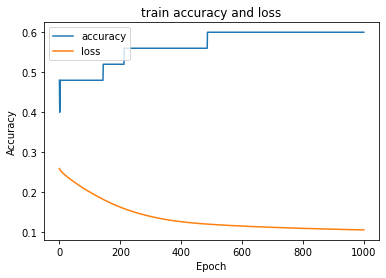


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: model\assets
OK


In [24]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['loss'])
plt.title('train accuracy and loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()
tf.saved_model.save(model, 'model')
# # saving to and loading from file

print("OK")


In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss:", results[0])
print("test accuracy:",results[1]*100,'%')

y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Test Accuracy is:', a*100)

Evaluate on test data
1/1 [==============================] - 0s 164ms/step - loss: 0.1772 - accuracy: 0.4286
test loss: 0.1771864891052246
test accuracy: 42.85714328289032 %
Test Accuracy is: 42.857142857142854
